<a href="https://colab.research.google.com/github/Tyriek-cloud/Cox-Hazard-Model-Simulation/blob/main/Simulated_Data_XGBoost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGBoost Model on Synthetic Data**

In [ ]:
# Installing the necessary models
!pip install xgboost lifelines pandas numpy scikit-learn gradio matplotlib

Alright. Let's start by doing the folloiwng:

*   Import all of the installed libraries.
*   Generate the synthetic/fake data.
*   Put all the data into an easy to work with dataframe.
*   Take a look at the data.






In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer

# Set a random seed for reproducibility
np.random.seed(42)

# Generate Independent variables (IVs)
n = 2000 # number of samples
age = np.random.randint(22, 65, n)
sex = np.random.choice(['Male', 'Female'], n)
income = np.random.normal(50000, 15000, n)
usage_frequency = np.random.randint(1, 8, n)
engagement = np.random.normal(5, 2, n)
satisfaction = np.random.normal(7, 1.5, n)

# Dependent variables (DV)
time_to_event = np.random.exponential(5, n)
censor = np.random.binomial(1, 0.8, n)

# Confounding variables
time_of_year = np.random.choice(['Winter', 'Spring', 'Summer', 'Fall'], n)
service_changes = np.random.choice([0, 1], n)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'sex': sex,
    'income': income,
    'usage_frequency': usage_frequency,
    'engagement': engagement,
    'satisfaction': satisfaction,
    'time_to_event': time_to_event,
    'censor': censor,
    'time_of_year': time_of_year,
    'service_changes': service_changes
})

# Call the head (first 5 rows) for observation
print(df.head())

   age     sex        income  usage_frequency  engagement  satisfaction  \
0   60  Female  58903.350834                5    2.176297      6.708669   
1   50  Female   5894.170480                2    4.522475      5.504714   
2   36  Female  59838.511648                2    8.862222      5.802839   
3   64  Female  52921.042921                5    6.717954      6.251257   
4   29    Male  49719.368653                6    4.242050      5.581261   

   time_to_event  censor time_of_year  service_changes  
0       5.060297       1       Summer                0  
1      10.666087       0         Fall                1  
2       3.805956       1       Spring                0  
3       7.117000       1       Summer                1  
4       7.199754       0       Spring                1  


That looks alright. However, it is not necessarily the most "real-world" looking. Let's observe some of the interactions between the variables and add some "noise" to the data.

In [3]:
# Label encoder for the sex and time of year variables
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['time_of_year'] = label_encoder.fit_transform(df['time_of_year'])

# One-hot encode the service_changes (outages) variable
df = pd.get_dummies(df, columns=['service_changes'], drop_first=True)

# Interaction terms and nonlinear transformations
df['age_income'] = df['age'] * df['income']
df['engagement_satisfaction'] = df['engagement'] * df['satisfaction']
df['usage_service_change'] = df['usage_frequency'] * df['service_changes_1']
df['age_squared'] = df['age'] ** 2
df['income_squared'] = df['income'] ** 2

# Create age bins
df['age_bins'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70], labels=False)
df['income'] = np.clip(df['income'], df['income'].quantile(0.05), df['income'].quantile(0.95))
df['income_log'] = np.log1p(df['income'])

# Scale continuous variables
scaler = StandardScaler()
scaled_features = ['age', 'income', 'usage_frequency', 'engagement', 'satisfaction', 'age_income',
                   'engagement_satisfaction', 'usage_service_change', 'age_squared', 'income_squared', 'income_log']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# Calling head to ensure that the data pre-processing is working
print(df.head())

        age  sex    income  usage_frequency  engagement  satisfaction  \
0  1.372783    0  0.653401         0.518315   -1.428284     -0.170196   
1  0.560028    0 -1.785924        -0.989145   -0.256056     -0.964047   
2 -0.577828    0  0.721745        -0.989145    1.912224     -0.767472   
3  1.697884    0  0.216197         0.518315    0.840878     -0.471799   
4 -1.146756    1 -0.017790         1.020802   -0.396165     -0.913574   

   time_to_event  censor  time_of_year  service_changes_1  age_income  \
0       5.060297       1             2              False    1.507644   
1      10.666087       0             0               True   -2.032951   
2       3.805956       1             1              False   -0.000640   
3       7.117000       1             2               True    1.346703   
4       7.199754       0             1               True   -0.779173   

   engagement_satisfaction  usage_service_change  age_squared  income_squared  \
0                -1.258092             -0

That looks fine. Now it's time to define and train the model. Ideally, we want to run the model on the best possible features/variables. Instead of doing the manual work of finding the best features, we will perform a search on the entire synthetic dataset.

In [5]:
# Time to fit a model
# Split data into training and validation sets
# Even though this is a synthetic dataset, there may be missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df.drop(['time_to_event', 'censor'], axis=1))
y = df[['time_to_event', 'censor']] # Time to event and censor indicator
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'alpha': [0.1, 0.5, 1.0],
    'lambda': [0.1, 0.5, 1.0],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'max_delta_step': [0, 1]
}

# Setup RandomizedSearchCV for XGBoost
random_search = RandomizedSearchCV(
    xgb.XGBRegressor(objective='survival:cox', eval_metric='cox-nloglik'),
    param_distributions=param_grid,
    n_iter=50,
    scoring=make_scorer(concordance_index),
    cv=3,
    verbose=1,
    random_state=42
)

# Perform Randomized Search
random_search.fit(X_train, y_train['time_to_event'])

# Print best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Concordance Index: {random_search.best_score_}")

# Train the final model with best parameters
best_params = random_search.best_params_
bst = xgb.XGBRegressor(objective='survival:cox', eval_metric='cox-nloglik', **best_params)
bst.fit(X_train, y_train['time_to_event'])

# Predict on the validation set
predictions = bst.predict(X_val)

# Calculate Concordance Index (C-index) for validation data
c_index = concordance_index(y_val['time_to_event'], predictions, y_val['censor'])
print(f'Concordance Index (C-index) for XGBoost model: {c_index}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 0, 'lambda': 0.1, 'gamma': 0.1, 'eta': 0.3, 'colsample_bytree': 0.8, 'alpha': 1.0}
Best Concordance Index: 0.5055389913534177
Concordance Index (C-index) for XGBoost model: 0.5088773428535


The model could potentially be stronger. However, it is better than a classical Cox Hazards Model. It is also possible that running this synthetic data on another Gradient Booster will produce better results. We will give that a try in a seperate notebook. Then, we will compare all of the results. For now, let's fit the curve and see what is happening.

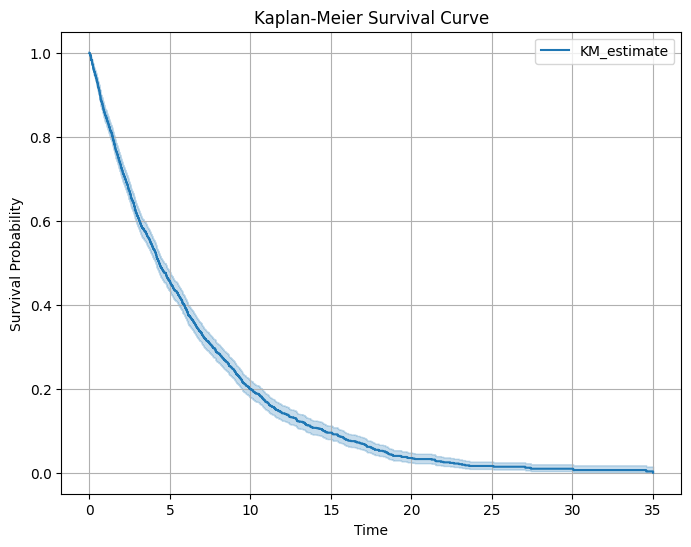

In [6]:
# Kaplan-Meier curve for true survival function
kmf = KaplanMeierFitter()
kmf.fit(df['time_to_event'], event_observed=df['censor'])
true_survival_function = kmf.survival_function_

# Plot the Kaplan-Meier survival function
plt.figure(figsize=(8, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

The curve is fit. Out of the three models I have built, it looks like the XGBoost model is performing the best. This could be for a few different reasons:

*   My parameters may be better fine tuned on the XGBoost model in comparison to the CatBoost model.
*   The amount of variables that are not at a categorical level are better on the model.
*   XGBoost could be handling overfitting, imputation, and other items better.
*   XGBoost appears to be doing regularization on the data a little better.

Let's see how this will look as a prototype on Gradio.




In [7]:
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Function to update and plot the Kaplan-Meier curve based on user input
def plot_kaplan_meier(censor_rate, time_mean):
    # Generate synthetic data (modify for dynamic adjustments based on user input)
    n = 2000  # Number of samples
    time_to_event = np.random.exponential(time_mean, n)
    censor = np.random.binomial(1, censor_rate, n)

    # Create DataFrame for the synthetic dataset
    df = pd.DataFrame({'time_to_event': time_to_event, 'censor': censor})

    # Kaplan-Meier fitting
    kmf = KaplanMeierFitter()
    kmf.fit(df['time_to_event'], event_observed=df['censor'])

    # Plotting the Kaplan-Meier survival function
    plt.figure(figsize=(8, 6))
    kmf.plot_survival_function()
    plt.title('Simulated Data Kaplan-Meier Survival Curve')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)

    # Return the plot to display in the Gradio interface
    return plt.gcf()

# Gradio Interface
iface = gr.Interface(
    fn=plot_kaplan_meier,
    inputs=[
        gr.Slider(minimum=0.5, maximum=1.0, step=0.05, value=0.8, label="Censoring Rate"),
        gr.Slider(minimum=1.0, maximum=10.0, step=0.5, value=5.0, label="Mean Time to Event")
    ],
    outputs=gr.Plot(),
    live=True,
    title="Simulated Data Kaplan-Meier Survival Curve",
    description="Adjust the censoring rate and time to event to visualize the Kaplan-Meier survival curve."
)

# Launch the Gradio app
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3d15e9481f2b052c49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Saving the model to a JSON file
# bst.save_model('xgb_survival_model.json')

In [ ]:
# Downloading
# from google.colab import files
# files.download('xgb_survival_model.json')

It looks like this is the model that I will demo on Gradio.